# Preprocessing of individual datasets
- takes 2-5 minutes total (up to n=4) or 10-15 min (with n=5)
- ironically, the main complication is for datasets which have been FW scaled--noisy reflections are overrepresented near the mean of the Wilson distributions and skew normalization. In the second step of anisotropic scaling I added weights to downweight the effects of noisy reflections.

In [1]:
# General tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import warnings
from mpl_toolkits    import mplot3d
from scipy.stats     import rice, foldnorm, nakagami, gamma 
from scipy.optimize  import least_squares, minimize
from time            import perf_counter

t_overall_start = perf_counter()


Bad key "text.kerning_factor" on line 4 in
C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import reciprocalspaceship as rs
import gemmi
from dw_tools import modify_ds, wilson, plots
from dw_tools import aniso_scaling_step_1 as aniso1
from dw_tools import aniso_scaling_step_2 as aniso2
from dw_tools import knn_tools as knn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors       import KNeighborsRegressor
rs.__version__

'0.9.5'

In [3]:
%autosave 300
%load_ext autoreload
%autoreload 2

Autosaving every 300 seconds


## Load data

In [4]:
# path="double_wilson_data\\" # Windows
path="double_wilson_data/"    # Unix
data_set_pairs = [("5kvx_phases", "5kw3_phases"),\
                  ("5e1y_phases", "2vwr_phases"),\
                  ("3pyp_phases", "1nwz_phases"),\
                  ("1otb_phases", "1nwz_phases"),\
                  ("4eul_phases", "GFP_SSRL_refine_54_final"),\
                  ("4eul_phases", "2y0g_phases"),\
                  ("4kjk_phases", "4kjj_phases", "4pst_phases", "4pss_phases"),\
                  ("e35cdef_OFF200ns_HD_2sig_varEll","e35cdef_200ns_HD_2sig_varEll")]
# example 1 fails on kNN regression
example=6
dataset=3
mtz1 = data_set_pairs[example][dataset] # omit .mtz
ds1 = rs.read_mtz(path + mtz1 + ".mtz")

# cleanup:
unpurged_count = ds1.shape[0];   ds1.dropna(inplace=True)
purged_count   = ds1.shape[0]
print(f"Discarded {unpurged_count-purged_count} out of {unpurged_count} records")

Discarded 4888 out of 130114 records


In [5]:
if False: #(example == 4) & (dataset==1): # - GFP_1.37A only contains intensities
    I = ds1["IMEAN"].to_numpy()
    SIGI = ds1["SIGIMEAN"].to_numpy()
    I[I<=0]=0.0001
    ds1["FP"] = np.sqrt(I)
    ds1["SIGFP"] = 0.5*np.sqrt(SIGI**2/I) #I played with using the Nakagami distribution instead, but it seems that its
                                          # std calculation is not very stable
                                          # so using naive error propagation instead.
if (example == 4) & (dataset==1):
    ds1["FP"] = ds1["F-obs-filtered"]
    ds1["SIGFP"] = ds1["SIGF-obs-filtered"]

In [6]:
# modify_ds.merge_anomalous(ds1)
# ds1.loc[ds1["I(+)"]>ds1["I(-)"],["I(+)","SIGI(+)","I(-)","SIGI(-)","IMEAN","SIGIMEAN","I","SIGI"]]

In [7]:
ds1.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 125226 entries, (0, 0, 4) to (39, 11, 5)
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype      
---  ------       --------------   -----      
 0   FREE         125226 non-null  MTZInt     
 1   FP           125226 non-null  SFAmplitude
 2   SIGFP        125226 non-null  Stddev     
 3   FC           125226 non-null  SFAmplitude
 4   PHIC         125226 non-null  Phase      
 5   FC_ALL       125226 non-null  SFAmplitude
 6   PHIC_ALL     125226 non-null  Phase      
 7   FWT          125226 non-null  SFAmplitude
 8   PHWT         125226 non-null  Phase      
 9   DELFWT       125226 non-null  SFAmplitude
 10  PHDELWT      125226 non-null  Phase      
 11  FOM          125226 non-null  Weight     
 12  FC_ALL_LS    125226 non-null  SFAmplitude
 13  PHIC_ALL_LS  125226 non-null  Phase      
dtypes: MTZInt(1), Phase(5), SFAmplitude(6), Stddev(1), Weight(1)
memory usage: 13.4 MB


Average observations per bin: 6261.3


(0, 260.4614646911621)

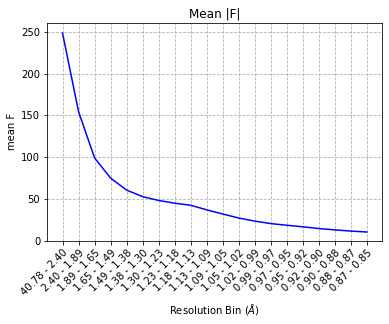

In [8]:
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F|")
plt.ylim(0,)

In [9]:
avg = ds1["FP"].mean()
ds1["FP"] = ds1["FP"]/avg
ds1["SIGFP"] = ds1["SIGFP"]/avg

In [10]:
modify_ds.ds_add_rs(ds1)
ds1.compute_dHKL(        inplace=True)
ds1.label_centrics(      inplace=True)
ds1.compute_multiplicity(inplace=True)

FREE         FP       SIGFP        FC      PHIC    FC_ALL  PHIC_ALL  \
H  K  L                                                                         
0  0  4      1  2.8044932  0.05830383  825.7139       0.0 162.67926     360.0   
      6      1  10.395409  0.18628633   1001.91       0.0 517.03625     360.0   
      8      1   1.542491  0.03740088 420.25833       0.0  40.20102 180.00006   
      10     1  0.3069339 0.044859573 162.54456 180.00002 158.52899 180.00002   
      12     1   8.327201   0.1514108 291.52777       0.0 326.31665       0.0   
...        ...        ...         ...       ...       ...       ...       ...   
39 10 8      1  0.3089418 0.054010805 17.798439 330.89325 14.168061 330.89346   
      9      0 0.08639776  0.14903614 6.9738607  36.90434  5.531968 36.904633   
   11 2      1 0.40976974 0.042837594 20.322289 331.65353 16.040634 331.65353   
      3      1 0.24143222  0.05797835  6.287707 242.49554 4.9577947 242.49548   
      5      1 0.23532471  0.06878057  9.079254  12.97458  7.135019 12.974663   

               FWT         PHWT    DELFWT      PHDELWT        FOM  FC_ALL_LS  \
H  K  L                                                                        
0  0  4  26.486237        360.0 136.19302    179.99998  0.6433594  251.74738   
      6  572.83545        360.0 55.799194        360.0 0.99999994   689.7521   
      8  23.339302 4.686958e-05  63.54032 4.686958e-05 0.10426663  11.707275   
      10 155.88245 8.028028e-06 314.41144 8.028027e-06 0.08224304  190.78728   
      12  546.5489          0.0 220.23224          0.0   0.999803  379.51947   
...            ...          ...       ...          ...        ...        ...   
39 10 8  16.309002    330.89346   2.14094    330.89346 0.94094133  17.798388   
      9   5.531968    36.904633       0.0          0.0        0.0   6.973908   
   11 2  25.422161    331.65353  9.381526    331.65353  0.9651278  20.322348   
      3  13.658117    242.49548  8.700322    242.49548 0.73545355   6.287718   
      5  12.401502    12.974663  5.266483    12.974662 0.79185534   9.079228   

          PHIC_ALL_LS     rs_a     rs_b      rs_c       dHKL  CENTRIC  EPSILON  
H  K  L                                                                         
0  0  4         360.0  0.00000  0.00000  0.040711    24.5635     True        2  
      6         360.0  0.00000  0.00000  0.061066  16.375666     True        2  
      8     359.99982  0.00000  0.00000  0.081422   12.28175     True        2  
      10    180.00002  0.00000  0.00000  0.101777     9.8254     True        2  
      12          0.0  0.00000  0.00000  0.122132   8.187833     True        2  
...               ...      ...      ...       ...        ...      ...      ...  
39 10 8      330.8934  1.14841  0.22310  0.081422 0.85272586    False        1  
      9      36.90457  1.14841  0.22310  0.091599  0.8521805    False        1  
   11 2     331.65353  1.14841  0.24541  0.020355 0.85141516    False        1  
      3     242.49548  1.14841  0.24541  0.030533  0.8512554    False        1  
      5     12.974647  1.14841  0.24541  0.050889 0.85074466    False        1  

[125226 rows x 20 columns]

### Checking reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. 

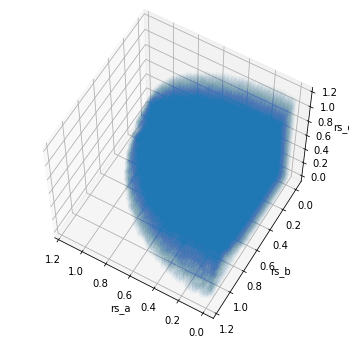

In [11]:
plt.ion
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"],alpha=0.01)
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

## Simple anisotropic normalization

In [12]:
# print(np.amin(ds1["FP"].to_numpy()))
# print(np.amax(ds1["FP"].to_numpy()))
# print(np.sum(np.isnan(ds1["FP"].to_numpy())))
res = minimize(         aniso1.anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,1],\
                                                                method='L-BFGS-B',jac=True,args=(ds1,"FP"))
# res = minimize(         aniso1.anisotropic_scaling_to_1_wilson_loss, [-5,0,0,-5,0,-5,0.25],\
#                                                                 method='nelder-mead',jac=True,args=(ds1,"FP"))
res_test, ep1, sigep1 = aniso1.anisotropic_scaling_to_1_wilson_loss(res.x, ds1, label="FP", nargout=3)
print(res.x)

ds1["EP_1_aniso_1"] = ep1
ds1["SIGEP_1_aniso_1"] = sigep1

[-2.39105219 -0.04544512  0.00412845 -2.35474857 -0.01723132 -2.35750579
  0.19014459]


Inspection of histograms. In the absence of a sigma cutoff, we get significant extra counts around the mode of the distribution. This must be the consequence of FW scaling. When we omit these, we see that the histogram is a bit shifted relative the Wilson distribution, suggesting noisy reflections skewed normalization.

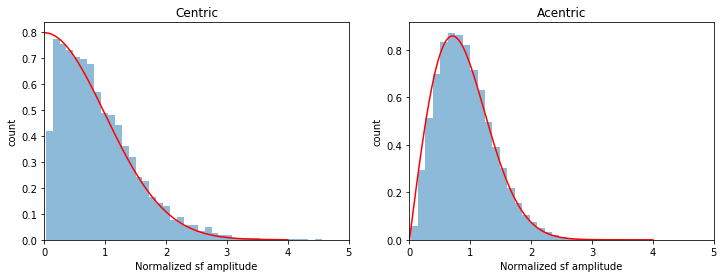

In [13]:
sig_cut = 0.1 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson seems to blame--the reflections with largest error 
              # will tend to get scaled to the mean of the Wilson distribution

x=np.linspace(0,4,500)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Centric")

plt.subplot(1,2,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Acentric"); 

## Anisotropic normalization with Fourier corrections

Since we're using quite a few parameters, we'll use a test set to choose the optimal order of the Fourier series.


In [14]:
rseed=1763
np.random.seed(rseed)
ds1["test_flag"] = (np.random.random((ds1.shape[0],1)) <0.85)

In [15]:
# typically the minimum is for n=3 or 4...
# see right below for typical run times by n (n=4: 2-3 min total)
# note that at higher values of n sometimes NaNs pop up

res=[0] # start with a dummy so next entries match their n
n_best = 0
best_loss = 9e9
for n in [1,2,3,4,5]:
    t1_start = perf_counter()
    params = aniso2.prepare_for_FFT(ds1, n=n, label="EP_1_aniso_1")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        init_guess = np.zeros((1,2*(n**3)))
        if n>1:
            init_guess[0,:res[-1].x.shape[0]]=res[-1].x
        else:
            init_guess[0]=np.array([1, 0])
        res_tmp = minimize(aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast, \
                           init_guess,method='L-BFGS-B', jac = True, \
                           args=(params,ds1["test_flag"].to_numpy()))
        res.append(res_tmp)
        res_test = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res_tmp.x, \
                                          params, bUse=~ds1["test_flag"].to_numpy(), nargout=1)
        if res_test[0] < best_loss:
            best_loss = res_test[0]
            n_best = n
        print(f"For n = {n} the test loss = {res_test[0]:.6}")
        t1_stop = perf_counter()  
        print(f"Elapsed time: {t1_stop-t1_start:.4} s")

For n = 1 the test loss = 19162.3
Elapsed time: 1.148 s
For n = 2 the test loss = 18229.0
Elapsed time: 10.38 s
For n = 3 the test loss = 18152.0
Elapsed time: 62.73 s
For n = 4 the test loss = 17945.6
Elapsed time: 293.0 s
For n = 5 the test loss = 17901.2
Elapsed time: 1.103e+03 s


In [16]:
# run for best n using *all* reflections and save
params = aniso2.prepare_for_FFT(ds1, n=n_best, label="EP_1_aniso_1")

loss, ep1, sigep1, scale1 = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res[n_best].x, params, \
                                                        bUse=np.ones((ds1.shape[0],),dtype=bool), nargout=3)

EP1_label = "EP_1_aniso_2"
ds1[EP1_label]   = ep1
ds1["SIG" + EP1_label]= sigep1
print(np.mean(ep1[ds1["CENTRIC"]==True]**2))
print(np.mean(ep1[ds1["CENTRIC"]==False]**2))

1.039686354206384
0.9390596478132908


Graphical inspection:

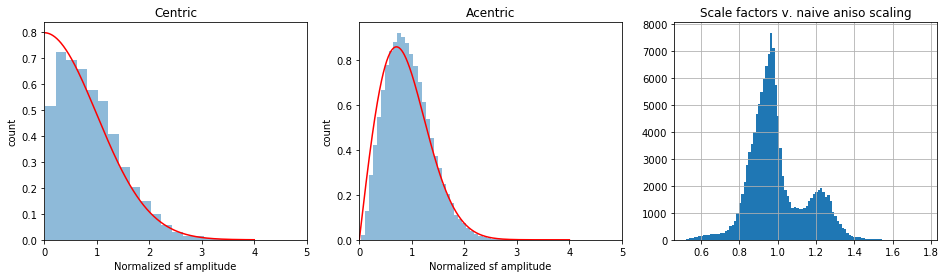

In [17]:
sig_cut = 0.1 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson scaling seems to blame.

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],20,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Acentric"); 

plt.subplot(1,3,3)
plt.hist(scale1,100); plt.grid()
plt.title("Scale factors v. naive aniso scaling")
plt.show()

## Normalization by regression estimates of Sigma
We're estimating $<|F|^2>$ locally in reciprocal space! Because the expected intensity is the same for acentric and centric reflections, we can do this in one go for all of them.

By Rupp eq. (7-104): $ \Sigma_N = \left<I\right>/\varepsilon_h $

Below are two implementations of $\Sigma$ estimation: using kernel ridge regression and k-nearest neighbors with custom weights. The former retains more of the correlation among data sets than the latter, but is **much** slower and more memory-intensive. It crashes on the cluster.

In [18]:
temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==True]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==False]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())

Distribution of multiplicities for centric reflections:
1    8651
2      81
Name: EPSILON, dtype: int64

Distribution of multiplicities for acentric reflections:
1    116494
Name: EPSILON, dtype: int64


We now perform k-nearest neighbor regression (with self excluded). The optimal $k$ (and uniform weights) are **much higher** when the input have already been anisotropically scaled. Larger $k$ is also slower...

In [19]:
gridsearch = False 
ncpu=1 #8 worked on the cluster
param_grid={"n_neighbors":[50,100,200,400,800],'weights':['uniform',knn.knn_weight_exp_p05, knn.knn_weight_norm_p05]}
#                                                                   knn.knn_weight_exp_p02, knn.knn_weight_norm_p02, \
#                                                                   knn.knn_weight_exp_p03, knn.knn_weight_norm_p03]}
if gridsearch: 
    knn_1 = GridSearchCV(KNeighborsRegressor(n_jobs=ncpu),param_grid=param_grid)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]].to_numpy(), (ds1[EP1_label].to_numpy()**2)) # these should be corrected for eps already
else:
    knn_1 = KNeighborsRegressor(800, weights=knn.knn_weight_exp_p05,n_jobs=ncpu)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]], (ds1[[EP1_label]].to_numpy()**2))

if gridsearch:
    print(knn_1.best_params_)

In [20]:
Sigma_1 = knn_1.predict(ds1[["rs_a", "rs_b", "rs_c"]]).reshape(-1,1)

In [21]:
E1    = ds1[        EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1) # We've already taken care of epsilon above
SIGE1 = ds1["SIG" + EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1)

ds1["EP_1_knn"]    = E1
ds1["SIGEP_1_knn"] = SIGE1

## Analysis

Average observations per bin: 6261.3
Average observations per bin: 6261.3
Average observations per bin: 6261.3
Average observations per bin: 6261.3


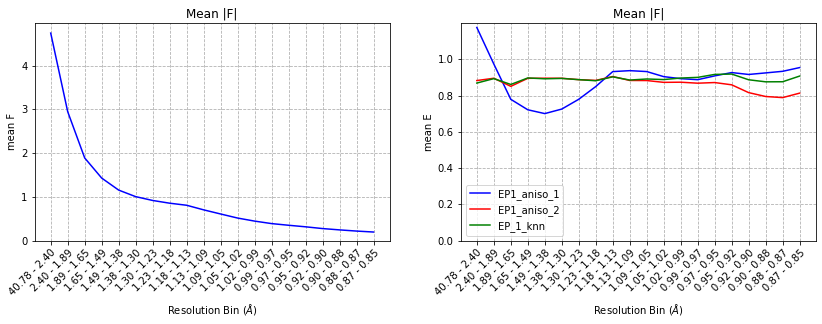

In [22]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F|")
plt.ylim(0,)

plt.subplot(1,2,2)
result_1, bin_labels_1 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_1", nbins=20,sigma_cut=0)
result_2, bin_labels_2 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_2", nbins=20,sigma_cut=0)
result_3, bin_labels_3 = plots.compute_meanF_byres(ds1, label="EP_1_knn",     nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_1, bin_labels_1, ylabel="mean E",color='b')
plots.plot_by_res_bin(result_2, bin_labels_2, ylabel="mean E",color='r')
plots.plot_by_res_bin(result_3, bin_labels_2, ylabel="mean E",color='g')
plt.title("Mean |F|")
plt.legend(["EP1_aniso_1", "EP1_aniso_2","EP_1_knn"])
plt.ylim(0,)
plt.show()

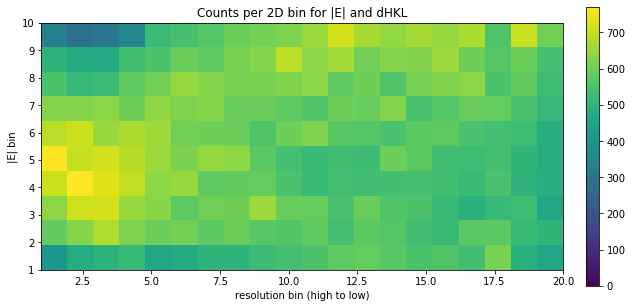

In [23]:
# Let's examine the distribution of dHKL and E in the data
sig_cut = 1
nbin    = (20,10)

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(ds1["dHKL"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(ds1["dHKL"], d_bins)
ds1["dHKL_bin"] = d_dig.flatten()
# print(d_bins)

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(ds1[EP1_label], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(ds1["EP_1_aniso_2"], ep1_bins)
ds1["EP_1_bin"] = ep1_dig.flatten()

H, xedges, yedges = np.histogram2d(ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP1_label]<sig_cut), "dHKL_bin"], \
                                   ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP1_label]<sig_cut), "EP_1_bin"],bins=nbin)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin (high to low)")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)

fname = mtz1 + "_n" + str(n_best) + "_" + EP1_label + "_" + str(rseed)+ ".png"
plt.savefig("results_figs/" + fname)
plt.show()

## Cleaning up 

In [24]:
ds1["rs_a"]           = ds1["rs_a"           ].astype("MTZReal")
ds1["rs_b"]           = ds1["rs_b"           ].astype("MTZReal")
ds1["rs_c"]           = ds1["rs_c"           ].astype("MTZReal")
ds1["EP_1_aniso_1"]   = ds1["EP_1_aniso_1"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_aniso_2"]   = ds1["EP_1_aniso_2"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_knn"]       = ds1["EP_1_knn"       ].astype("NormalizedSFAmplitude")
ds1["SIGEP_1_aniso_1"]= ds1["SIGEP_1_aniso_1"].astype("Stddev")
ds1["SIGEP_1_aniso_2"]= ds1["SIGEP_1_aniso_2"].astype("Stddev")
ds1["SIGEP_1_knn"]    = ds1["SIGEP_1_knn"    ].astype("Stddev")
# ds1.info()

Let's check whether we still have unsupported column datatypes around!

In [25]:
modify_ds.check_col_dtypes(ds1)

Column "CENTRIC" has a datatype not supported by the MTZ format.
Column "test_flag" has a datatype not supported by the MTZ format.
Column "dHKL_bin" has a datatype not supported by the MTZ format.
Column "EP_1_bin" has a datatype not supported by the MTZ format.


In [26]:
# We'll have to add centric flags back later
ds1.write_mtz(path + mtz1 + "_scaled.mtz",skip_problem_mtztypes=True)
t_overall_end = perf_counter()
print("Total elapsed time:", t_overall_end-t_overall_start)

Total elapsed time: 1539.3903441


## Obsolete stuff

4.504891266613296


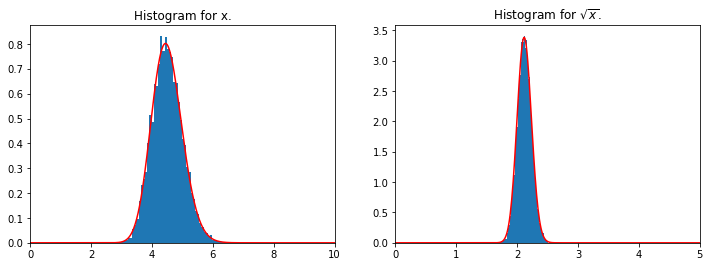

In [27]:
mu = 4.5
var = 0.5**2
theta = var/mu
k = mu/theta
m = k
Om = m*theta
std = nakagami.std(m, loc=0, scale=np.sqrt(Om))
x = gamma.rvs(a=k, scale=theta, size=10000)
base=np.linspace(0,12,1000)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x,50,density=True)
plt.plot(base, gamma.pdf(x=base, a=k, scale=theta),'r-')
plt.title(r"Histogram for x."); plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(np.sqrt(x),50,density=True)
print(np.mean(x))
plt.plot(base, nakagami.pdf(x=base, nu=k, scale=np.sqrt(Om)),'r-')
plt.title(r"Histogram for $\sqrt{x}$."); plt.xlim([0,5])
plt.show()